<a href="https://colab.research.google.com/github/Mohammad-H-Zahrawi/Projects/blob/main/Text_Classification_Question_Classification_AI_Fellowship_Challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Text Classification - Question Classification




In [1]:
# we reccommend to rum this notebook using GPU 

In [2]:
# Are we using a GPU?
!nvidia-smi

Mon Dec 13 20:05:09 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   70C    P0    86W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Importing Modules and Packages

In [3]:
# State-of-the-art Natural Language Processing packages for TensorFlow 2.0 and PyTorch

In [4]:
pip install transformers

In [5]:
pip install sentencepiece

In [6]:
pip install pytorch-transformers

In [7]:
import numpy as np
import pandas as pd
import re
import random

#visulaization libraries
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#import NLTK library which focus on making natural human language usable by computer programs
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords


from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer

#importing svm model and multi-class classifier
from sklearn.svm import LinearSVC
from sklearn.multiclass import OneVsRestClassifier

#importing metric evaluation
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score 
from sklearn.metrics import average_precision_score
from sklearn.metrics import recall_score

import tensorflow as tf
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras import layers

from keras.callbacks import TensorBoard
from tensorflow.keras import layers
import datetime
import tensorflow_hub as hub


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [8]:
import torch
import torchvision
from keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
from tensorflow.keras.utils import plot_model


In [9]:
from pytorch_transformers import XLNetModel, XLNetTokenizer, XLNetForSequenceClassification


### Importing Data 

In [10]:
# Get data (10% of labels)
# Download data
train_url = 'https://raw.githubusercontent.com/Mohammad-H-Zahrawi/Projects/main/Text_classification_AI-Fellowship/train.csv'
test_url = 'https://raw.githubusercontent.com/Mohammad-H-Zahrawi/Projects/main/Text_classification_AI-Fellowship/test.csv'

train = pd.read_csv(train_url)
test = pd.read_csv(test_url)

In [11]:
train.head(3)

,text
0,DESC:manner How did serfdom develop in and the...
1,ENTY:cremat What films featured the character ...
2,DESC:manner How can I find a list of celebriti...


In [12]:
test.head(3)

,text
0,NUM:dist How far is it from Denver to Aspen ?
1,"LOC:city What county is Modesto , California in ?"
2,HUM:desc Who was Galileo ?


In [13]:
train.describe()

,text
count,5452
unique,5382
top,NUM:code What is Columbia Tristar 's phone num...
freq,3


In [14]:
test.describe()

,text
count,500
unique,500
top,ENTY:plant What is the state flower of Michigan ?
freq,1


### preparing the data
extract labels from texts using Regex

In [15]:
train['class']=train['text'].str.extract(r'(^\w*:\w*)',expand=True)
train['text']=train['text'].str.replace(r'(^\w*:\w*)','')

test['class']=test['text'].str.extract(r'(^\w*:\w*)',expand=True)
test['text']=test['text'].str.replace(r'(^\w*:\w*)','')

In [16]:
train.head(3)

,text,class
0,How did serfdom develop in and then leave Rus...,DESC:manner
1,What films featured the character Popeye Doyle ?,ENTY:cremat
2,How can I find a list of celebrities ' real n...,DESC:manner


In [17]:
test.head(3)

,text,class
0,How far is it from Denver to Aspen ?,NUM:dist
1,"What county is Modesto , California in ?",LOC:city
2,Who was Galileo ?,HUM:desc


In [18]:
print(f'length of training set is {len(train)}\nlength of test set is {len(test)}')

length of training set is 5452
length of test set is 500


In [19]:
# number of classes
len(train['class'].unique())

50

In [20]:
# checking the missing values in training set
train.isnull().sum()

text     0
class    0
dtype: int64

In [21]:
test.isnull().sum()

text     0
class    0
dtype: int64

### Exploratory Data Analysis

In [22]:
def count_labels(df):
  count_label = pd.DataFrame(df['class'].value_counts())
  count_label=count_label.reset_index()
  count_label.columns=['class','number of questions (texts)']
  return count_label

In [23]:
#class distribution in training dataset
count_labels(train).head(4)

,class,number of questions (texts)
0,HUM:ind,962
1,LOC:other,464
2,DESC:def,421
3,NUM:count,363


In [24]:
# class distribution in test set
count_labels(test).head(4)

,class,number of questions (texts)
0,DESC:def,123
1,HUM:ind,55
2,LOC:other,50
3,NUM:date,47


In [25]:
#distribuation of classes in training dataset (highest 15 classes)

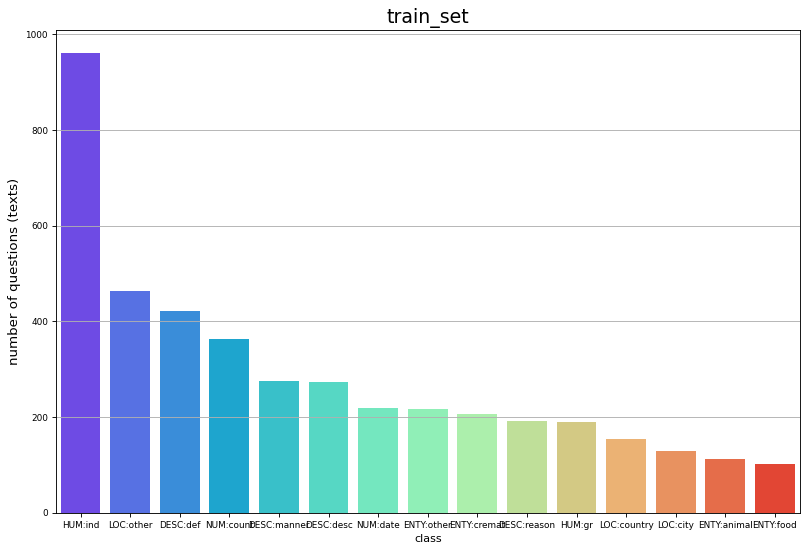

In [26]:
plt.figure(figsize=(12,8),dpi=80)
plt.grid(axis='y')
plt.tick_params(axis='both', labelsize=8)
plt.xlabel('category',fontsize=10)
plt.ylabel('Number of comments',fontsize=12)
plt.title('train_set',fontsize=17)
sns.barplot(x='class',y='number of questions (texts)',data = count_labels(train).iloc[:15],palette='rainbow')

In [27]:
#distribuation of classes in test dataset (highest 15 classes)

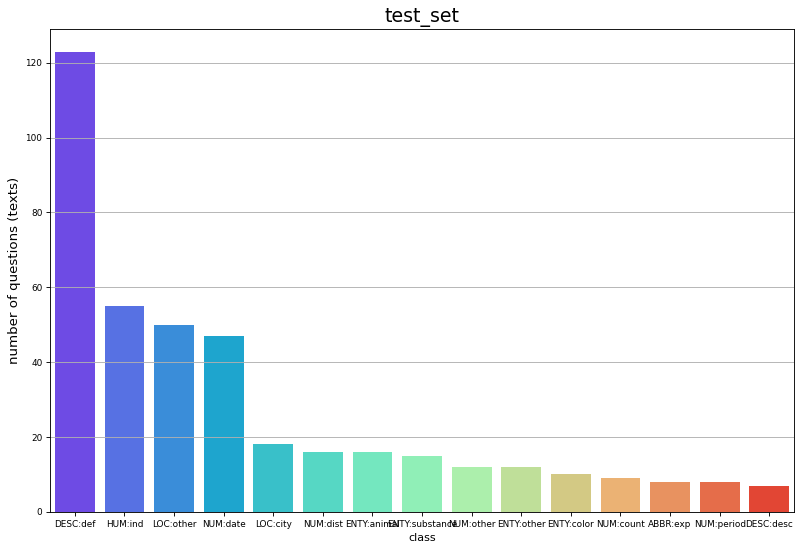

In [28]:
plt.figure(figsize=(12,8),dpi=80)
plt.grid(axis='y')
plt.tick_params(axis='both', labelsize=8)
plt.xlabel('category',fontsize=10)
plt.ylabel('Number of comments',fontsize=12)
plt.title('test_set',fontsize=17)
sns.barplot(x='class',y='number of questions (texts)',data = count_labels(test).iloc[:15],palette='rainbow')

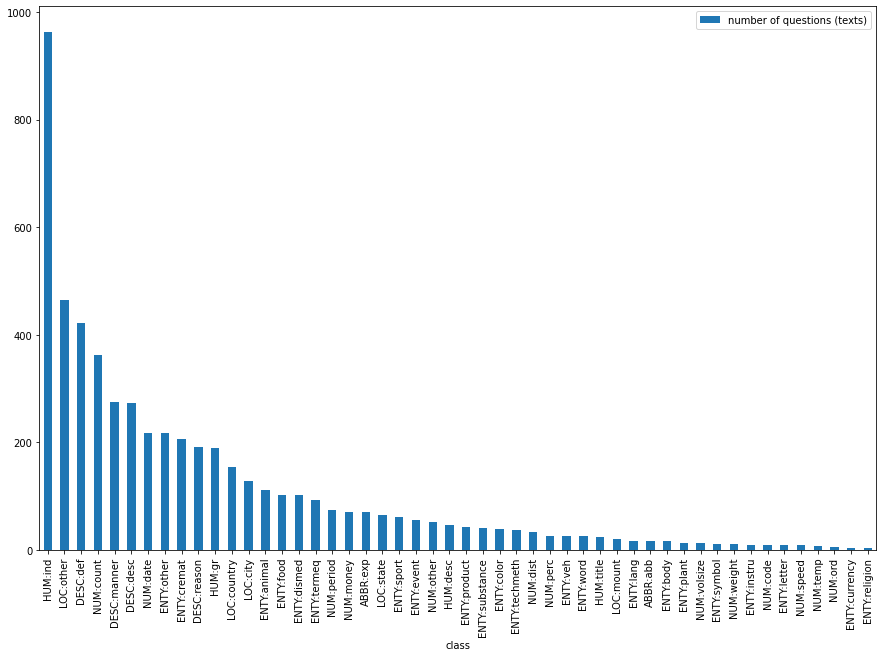

In [29]:
#visualize 50 classes in one chart 
plt.rcParams['figure.figsize'] = [15, 10]
count_labels(train).plot.bar(x='class',y='number of questions (texts)')

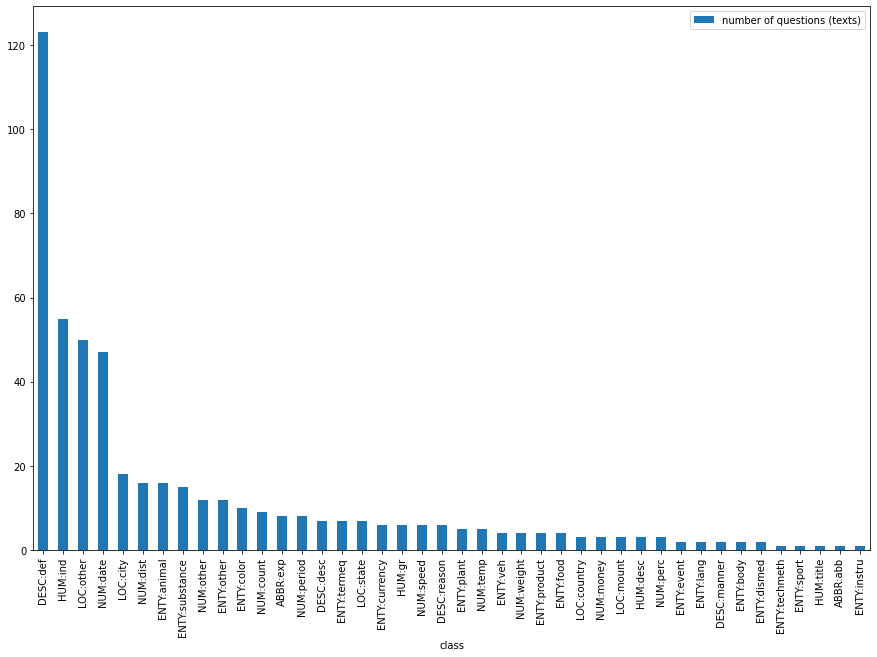

In [30]:
plt.rcParams['figure.figsize'] = [15, 10]
count_labels(test).plot.bar(x='class',y='number of questions (texts)')

**we have noticed in above bar graphs that both training and test sets have similar distibution of classes**

In [31]:
len_training = train.text.str.len()
len_testing = test.text.str.len()


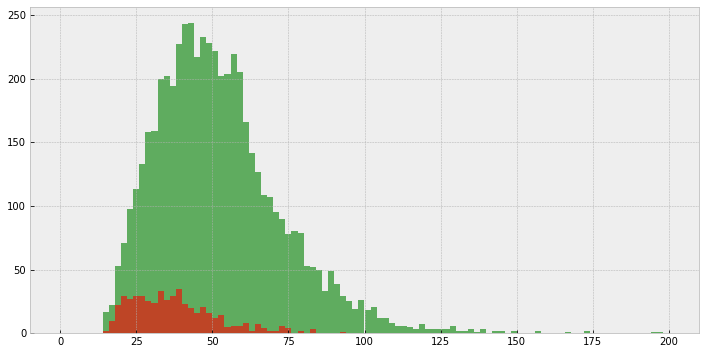

In [32]:
#The histgram plot of text length distribution
plt.figure(figsize=(12,6))
plt.style.use('bmh')
len_training.hist( facecolor='g', alpha=0.6,bins=100,range=(0,200))
len_testing.hist( facecolor='r', alpha=0.6,bins=100,range=(0,200))

In [33]:
len_training.mean(),len_testing.mean()

(51.63206162876009, 36.958)

In [34]:
print(f'The average of length of text in training set is {len_training.mean()}')
print(f'The average of length of text in training set is {len_testing.mean()}')

The average of length of text in training set is 51.63206162876009
The average of length of text in training set is 36.958


In [35]:
max_text_training = len_training.max()
max_text_training

197

In [36]:
# the longest question is 197, which is very far from the average. we invistigate it by print it.
[i for i in train['text'] if len(i)==max_text_training]

[' Why do people get goosebumps when they have something emotional happen to them , like when they hear a beautiful piece of music , or see something beautiful , or get aroused by someone they love ?']

## preprocessing

### NLTK Normalization

In [37]:
special_char = re.compile('[/(){}\[\]\|@,;]')
bad_char = re.compile('[^A-Z0-9a-z #+_.]')
NEW_LINE = re.compile('\n')

**Note**: we did not exclude full stop "." because it used in abbreviations like U.S.S.R.

In [38]:
# eliminate special characters and new line as well.
train['text']=train['text'].apply(lambda x:''.join([bad_char.sub(' ',word) for word in x]))
train['text']=train['text'].apply(lambda x:''.join([special_char.sub(' ',word) for word in x]))

In [39]:
test['text']=test['text'].apply(lambda x:''.join([bad_char.sub(' ',word) for word in x]))
test['text']=test['text'].apply(lambda x:''.join([special_char.sub(' ',word) for word in x]))

In [40]:
# tokenizing texts by breaking them into individual linguistic units 
train['text_tokens']=train['text'].apply(str).apply(lambda x:nltk.word_tokenize(x))
test['text_tokens']=test['text'].apply(str).apply(lambda x:nltk.word_tokenize(x))
train.head()

,text,class,text_tokens
0,How did serfdom develop in and then leave Rus...,DESC:manner,"[How, did, serfdom, develop, in, and, then, le..."
1,What films featured the character Popeye Doyle,ENTY:cremat,"[What, films, featured, the, character, Popeye..."
2,How can I find a list of celebrities real n...,DESC:manner,"[How, can, I, find, a, list, of, celebrities, ..."
3,What fowl grabs the spotlight after the Chine...,ENTY:animal,"[What, fowl, grabs, the, spotlight, after, the..."
4,What is the full form of .com,ABBR:exp,"[What, is, the, full, form, of, .com]"


In [41]:
#dublicating text_tokens column
train['tokens_without_stopwords']=train['text_tokens']
test['tokens_without_stopwords']=test['text_tokens']

Stop Words: A stop word is a commonly used word (such as “the”, “a”, “an”, “in”) that a search engine has been programmed to ignore

In [42]:
#removing stopwords from text to reduce training dataset size, hence decrease training time
for i in range(0,len(train)):
  train['tokens_without_stopwords'][i]=[word for word in train['tokens_without_stopwords'][i] if word.lower() not in stopwords.words('english')]

In [43]:
#removing stopwords in test set
for i in range(0,len(test)):
  test['tokens_without_stopwords'][i]=[word for word in test['tokens_without_stopwords'][i] if word.lower() not in stopwords.words('english')]

In [44]:
train.head(2)

,text,class,text_tokens,tokens_without_stopwords
0,How did serfdom develop in and then leave Rus...,DESC:manner,"[How, did, serfdom, develop, in, and, then, le...","[serfdom, develop, leave, Russia]"
1,What films featured the character Popeye Doyle,ENTY:cremat,"[What, films, featured, the, character, Popeye...","[films, featured, character, Popeye, Doyle]"


In [45]:
test.head(2)

,text,class,text_tokens,tokens_without_stopwords
0,How far is it from Denver to Aspen,NUM:dist,"[How, far, is, it, from, Denver, to, Aspen]","[far, Denver, Aspen]"
1,What county is Modesto California in,LOC:city,"[What, county, is, Modesto, California, in]","[county, Modesto, California]"


## Machine Learning Models

### class transformations

In [46]:
encoder = OneHotEncoder().fit(train[['class']])

In [47]:
train_y = encoder.transform(train[['class']]).toarray()
test_y = encoder.transform(test[['class']]).toarray()

In [48]:
train_y

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [49]:
train_y_dummies = pd.get_dummies(train['class'])
test_y_dummies = pd.get_dummies(test['class'])
test_y_dummies.shape

(500, 42)

**Note:** we cannot apply pd.get_dummies() for encoding categorical features because there are 42 classes in test set. 

### Data transformation

In [50]:
# we want to concatenate the words together to feed it to TfidfVectorizer
train['tokens_without_stopwords']=train['tokens_without_stopwords'].apply(list).apply(lambda x:' '.join(x))
test['tokens_without_stopwords']=test['tokens_without_stopwords'].apply(list).apply(lambda x:' '.join(x))

train['text_tokens']=train['text_tokens'].apply(list).apply(lambda x:' '.join(x))
test['text_tokens']=test['text_tokens'].apply(list).apply(lambda x:' '.join(x))

train.head(2)

,text,class,text_tokens,tokens_without_stopwords
0,How did serfdom develop in and then leave Rus...,DESC:manner,How did serfdom develop in and then leave Russia,serfdom develop leave Russia
1,What films featured the character Popeye Doyle,ENTY:cremat,What films featured the character Popeye Doyle,films featured character Popeye Doyle


In [51]:
# apply TfidfVectorizer to convert text to matrix of TF-IDF features

In [52]:
def tfidf_features (x_train,x_test):
    tfidf_vectorizer = TfidfVectorizer()
    tfidf_vectorizer.fit(x_train)
    x_train = tfidf_vectorizer.transform(x_train)
    x_test = tfidf_vectorizer.transform(x_test)
    return (x_train,x_test,tfidf_vectorizer.vocabulary_)

### Training the classifier using SVM machine learning

We recommend to train the model twice, first excluding stopwords from text and again including stopwords.

#### Model 0: SVM without stopwords Model

In [53]:
x_train_tfidf , x_test_tfidf, tfidf_vocab = tfidf_features(train['tokens_without_stopwords'],test['tokens_without_stopwords'])
tfidf_reversed_vocab = {i:word for word,i in tfidf_vocab.items()}

In [54]:
#checking the shape of tfidf data
print('x_train_tfidf shape ', x_train_tfidf.shape)
print('x_test_tfidf shape ', x_test_tfidf.shape)

x_train_tfidf shape  (5452, 8289)
x_test_tfidf shape  (500, 8289)


In [55]:
import numpy as np
np.seterr(divide='ignore', invalid='ignore')

{'divide': 'warn', 'invalid': 'warn', 'over': 'warn', 'under': 'ignore'}

In [56]:
model_0 = OneVsRestClassifier(LinearSVC(random_state=0)).fit(x_train_tfidf,train_y)
model_0_predictions = model_0.predict(x_test_tfidf)

In [57]:
# Function to evalaute: accuracy, precision, recall, F1-score
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
  """
  Calculates model accuracy, precision, recall and f1 score of a binary classification model.

  Args:
  ----
  y_true = true labels in the form of a 1D array
  y_pred = predicted label in the form of a 1D array

  Returns a dictionary of accuracy, precision, recall and f1-score between y_true and y_pred.
  """
  # Calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred) * 100 # get accuracy score in percentage value
  # Calculate model precision, recall and f1 score using "weighted" avergage
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  # Create a dictionary of model results
  model_results = {"accuracy": model_accuracy,
                   "precision": model_precision,
                   "recall": model_recall,
                   "f1": model_f1}
  return model_results

In [58]:
print('Model Evaluation Metrics excluding stopwords')
model_0_results = calculate_results(test_y,model_0_predictions)
model_0_results

Model Evaluation Metrics excluding stopwords


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'accuracy': 37.0,
 'f1': 0.4746731018094369,
 'precision': 0.7823285892052809,
 'recall': 0.388}

#### Model 1: SVM with stopwords Model

In [59]:
x_train_tfidf , x_test_tfidf, tfidf_vocab = tfidf_features(train['text_tokens'],test['text_tokens'])
tfidf_reversed_vocab = {i:word for word,i in tfidf_vocab.items()}

In [60]:
model_1 = OneVsRestClassifier(LinearSVC(random_state=0)).fit(x_train_tfidf,train_y)
model_1_predictions_withStopwords = model_1.predict(x_test_tfidf)

In [61]:
print('Model Evaluation Metrics including stopwords')
model_1_results = calculate_results(test_y,model_1_predictions_withStopwords)
model_1_results

Model Evaluation Metrics including stopwords


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'accuracy': 68.60000000000001,
 'f1': 0.7538799557088292,
 'precision': 0.8701702743797084,
 'recall': 0.712}

**Removing stop words not always a good idea**

We have noticed the model including stopwords in text performs better than without stopwords according to the evaluation metrics. 

You can use a pipeline to train the previous models.

In [62]:
from sklearn.pipeline import Pipeline

In [63]:
model_pipe = Pipeline([
                    ("tfidf", TfidfVectorizer()), # convert words to numbers using tfidf
                    ("svm", OneVsRestClassifier(LinearSVC(random_state=0))) # model the text
])

# Fit the pipeline to the training data (with stopwords)
model_pipe.fit(train['text_tokens'], train_y)

prediction_pipeline = model_pipe.predict(test['text_tokens'])

In [64]:
model_1_results_pipeline = calculate_results(prediction_pipeline,test_y)
model_1_results_pipeline

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'accuracy': 68.60000000000001,
 'f1': 0.850406147577628,
 'precision': 0.8326790732037869,
 'recall': 0.9035532994923858}

## Deep Learning Models

In this section, we are going to use TensorFlow and Keras platforms to build deep learning text classification models. we are going to start with preprocessing using Keras.

### preprcessing using Keras

converting text into numbers using text vectorization and embedding

In [65]:
#use the default TextVectorization
text_vectorizer = TextVectorization()

In [66]:
 # Find average number of tokens (words) in training tweets
round(np.sum([len(i.split()) for i in train['text_tokens']])/len(train['text_tokens']))

9

In [67]:
# Setup text vectorization variables
max_vocab_length = 10000 # max number of words to have in our vocabulary
max_length = 9 # max length

text_vectorizer = TextVectorization(max_tokens=max_vocab_length,
                                    output_mode='int',
                                    output_sequence_length = max_length)

In [68]:
# Fit the text vectorizer to the training text
text_vectorizer.adapt(train['text_tokens'])

In [69]:
# Get the unique words in the vocabulary
words_in_vocab = text_vectorizer.get_vocabulary()
top_5_words = words_in_vocab[:5]
print('The most common tokens in text vectorizer are',top_5_words)
print('length of vocabulary in text vectorizer is',len(words_in_vocab))


The most common tokens in text vectorizer are ['', '[UNK]', 'the', 'what', 'is']
length of vocabulary in text vectorizer is 8475


Creating an Embedding using an Embedding Layer

In [70]:
embedding = layers.Embedding(input_dim = max_vocab_length, # set inout shape
                             output_dim = 128, # set size of embedding vector
                             embeddings_initializer = 'uniform', # default initialize randomly
                             input_length = max_length) # how long of each input
embedding

In [71]:
#just testing vectorizer and embedding layer
random_sentence = random.choice(train['text_tokens']) 
print(random_sentence,'\n')
print(text_vectorizer([random_sentence]),'\n')
print(embedding(text_vectorizer([random_sentence])))

What keeps clouds in the air 

tf.Tensor([[   3 2851 1177    6    2  302    0    0    0]], shape=(1, 9), dtype=int64) 

tf.Tensor(
[[[ 0.01578238  0.01128043  0.03505179 ...  0.03025929  0.04181949
    0.03303461]
  [-0.02166722  0.01367452  0.04924083 ... -0.02277225  0.03488517
   -0.01717026]
  [-0.03520777  0.03993844 -0.03174033 ...  0.00363861  0.0064666
   -0.01459843]
  ...
  [-0.02595404 -0.00462107 -0.00988049 ... -0.00172368  0.02051396
    0.02474791]
  [-0.02595404 -0.00462107 -0.00988049 ... -0.00172368  0.02051396
    0.02474791]
  [-0.02595404 -0.00462107 -0.00988049 ... -0.00172368  0.02051396
    0.02474791]]], shape=(1, 9, 128), dtype=float32)


### Models

We have got our input prepared, it is a matter of figuring out which machine learning (deep learning) models performed best.
more specifically, we will be building the following:
* **Model 0**: SVM without stopwords Model 
* **Model 1**: SVM with stopwords Model
* **Model 2**: LSTM Model
* **Model 3**: GRU Model
* **Model 4**: Bidirectional -LSTM Model
* **Model 5**: 1D Convolutional Neural Network
* **Model 6**: TensorFlow Hub Pretrained Feature Extractor (Transfer Learning)
* **Model 7**: XLNet

We have done modelling model 0 and 1 in machine learning section ,let's start with our deep model **LSTM Model**


⚡ Each experiment will go through the following steps:
* Construct the model
* Train the model
* Make prediction with model
* Track predictionevaluation metrics for later comparsion




### Model 2: LSTM

In [72]:
# Plot the validation and training data separately
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  """ 
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.figure(figsize=(12,8))
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure(figsize=(12,8))
  
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

In [73]:
def create_tensorboard_callback(dir_name, experiment_name):
  """
  creates a TensorBoard callback instand to store log files.
  stores log files with the filepath:
    "dir_name/experiment_name/current_datetime"
  
  Args:
    die_name: target directory to store TensorBoard log files
    experiment_name: name of experiment directory (e.g. efficient_model_1)
  """

  log_dir = dir_name + "/" + experiment_name + "/" +datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorBoard_callback = tf.keras.callbacks.TensorBoard(
      log_dir = log_dir
  )
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorBoard_callback

In [74]:
# Create LSTM model
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = embedding(x)
print(f"After embedding: {x.shape}")
x = layers.LSTM(64, activation="tanh", return_sequences=True)(x) # use return_sequences=True if you want to stack recurrent layers 
print(f"After LSTM cell with return_sequences=True: {x.shape}")
x = layers.LSTM(64, activation="tanh")(x)
print(f"After LSTM cell: {x.shape}")
x = layers.Dense(64, activation="relu")(x) # optional dense layer to have on top of LSTM layer
outputs = layers.Dense(50, activation="softmax")(x)
model_2 = tf.keras.Model(inputs, outputs, name="model_2_LSTM")


After embedding: (None, 9, 128)
After LSTM cell with return_sequences=True: (None, 9, 64)
After LSTM cell: (None, 64)


In [75]:
# Compile model
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit model
model_2_history = model_2.fit(train['text_tokens'],
                        train_y,
                        epochs=5,
                        validation_data=(test['text_tokens'], test_y),
                        callbacks=[create_tensorboard_callback(dir_name='model_logs',
                                                               experiment_name="model_2_LSTM")])

Saving TensorBoard log files to: model_logs/model_2_LSTM/20211213-200545
Epoch 1/5
171/171 [==============================] - 8s 19ms/step - loss: 2.8505 - accuracy: 0.2817 - val_loss: 2.1457 - val_accuracy: 0.5140
Epoch 2/5
171/171 [==============================] - 2s 13ms/step - loss: 1.7105 - accuracy: 0.5413 - val_loss: 1.7474 - val_accuracy: 0.5940
Epoch 3/5
171/171 [==============================] - 2s 13ms/step - loss: 1.1884 - accuracy: 0.6675 - val_loss: 1.6890 - val_accuracy: 0.6220
Epoch 4/5
171/171 [==============================] - 2s 13ms/step - loss: 0.8650 - accuracy: 0.7573 - val_loss: 1.6106 - val_accuracy: 0.6480
Epoch 5/5
171/171 [==============================] - 2s 13ms/step - loss: 0.6405 - accuracy: 0.8191 - val_loss: 1.7575 - val_accuracy: 0.6520


In [76]:
model_2.summary()

Model: "model_2_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 9)                0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 9, 128)            1280000   
                                                                 
 lstm (LSTM)                 (None, 9, 64)             49408     
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                      

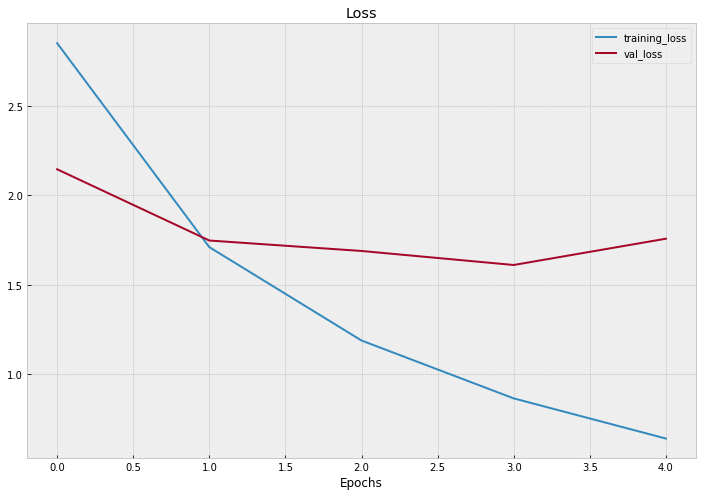

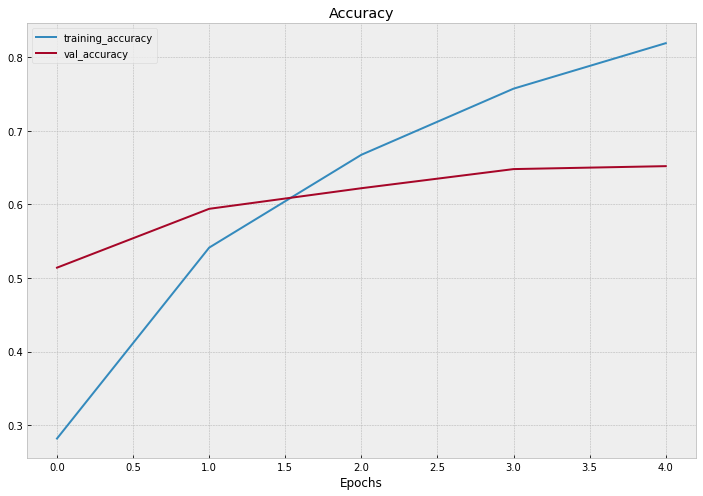

In [77]:
plot_loss_curves(model_2_history)

In [78]:
# Make predictions on the validation dataset
model_2_pred_probs = model_2.predict(test['text_tokens'])
model_2_pred_probs.shape, model_2_pred_probs[:1]

((500, 50), array([[2.2748323e-05, 9.5859264e-07, 9.7798977e-05, 6.3007570e-07,
         3.6299601e-03, 2.3064768e-02, 2.0957437e-07, 2.2457449e-09,
         2.7487542e-05, 1.7204167e-07, 1.5388270e-08, 1.2013590e-04,
         2.1845253e-06, 2.4496656e-05, 8.6412138e-07, 5.4473235e-06,
         3.8276718e-07, 4.5086762e-07, 5.8963590e-09, 1.7279608e-07,
         3.5484680e-07, 6.1788126e-09, 1.8639101e-08, 7.0504866e-05,
         4.1578296e-08, 2.6610162e-04, 2.9890357e-09, 5.2541520e-07,
         5.1867919e-09, 2.6694238e-08, 1.0151441e-06, 7.4853539e-05,
         5.3992495e-04, 4.3762066e-05, 6.4842116e-06, 2.6802976e-05,
         1.7128525e-06, 4.9517434e-06, 1.0866362e-03, 1.0988900e-05,
         7.8834927e-01, 2.9276707e-03, 2.3063308e-06, 1.1412562e-02,
         6.1636724e-06, 1.4769325e-01, 5.4937848e-03, 2.4023524e-04,
         1.3460044e-02, 1.2811269e-03]], dtype=float32))

In [79]:
#This cell replace all values in numpy array into zeros except the highest value into one
model_2_pred = [tf.cast(x==np.max(x),tf.int32) for x in model_2_pred_probs]
model_2_pred=np.array(model_2_pred)
print(model_2_pred.shape,'\n',model_2_pred[0])

(500, 50) 
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 0]


In [80]:
model_2_results = calculate_results(test_y,model_2_pred)
model_2_results

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'accuracy': 65.2,
 'f1': 0.6388410105036928,
 'precision': 0.6527415256152165,
 'recall': 0.652}

### Model 3: GRU
GRU = Gated recurrent unit (one of the most popular and useful recurrent layer types)


In [81]:
# Build an RNN using the GRU cell
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.GRU(64, activation="tanh", return_sequences=True)(x) # return_sequences=True is required for stacking recurrent cells
print(x.shape)
x = layers.GRU(64, activation="tanh")(x)
outputs = layers.Dense(50, activation="softmax")(x)
model_3 = tf.keras.Model(inputs, outputs, name="model_3_GRU")

(None, 9, 64)


In [82]:
# Get a summary
model_3.summary()

Model: "model_3_GRU"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 9)                0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 9, 128)            1280000   
                                                                 
 gru (GRU)                   (None, 9, 64)             37248     
                                                                 
 gru_1 (GRU)                 (None, 64)                24960     
                                                                 
 dense_2 (Dense)             (None, 50)                3250      
                                                       

In [83]:
# Compile model_3 (GRU)
model_3.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit model
model_3_history = model_3.fit(train['text_tokens'],
                              train_y,
                              epochs=5,
                              validation_data=(test['text_tokens'],test_y),
                              callbacks=[create_tensorboard_callback(dir_name='model_logs',
                                                                     experiment_name="model_3_GRU")])

Saving TensorBoard log files to: model_logs/model_3_GRU/20211213-200612
Epoch 1/5
171/171 [==============================] - 7s 18ms/step - loss: 2.4086 - accuracy: 0.3648 - val_loss: 2.1160 - val_accuracy: 0.4500
Epoch 2/5
171/171 [==============================] - 2s 12ms/step - loss: 1.2610 - accuracy: 0.6482 - val_loss: 1.7370 - val_accuracy: 0.6040
Epoch 3/5
171/171 [==============================] - 2s 12ms/step - loss: 0.8134 - accuracy: 0.7949 - val_loss: 1.7019 - val_accuracy: 0.6440
Epoch 4/5
171/171 [==============================] - 2s 13ms/step - loss: 0.5268 - accuracy: 0.8740 - val_loss: 1.7071 - val_accuracy: 0.6440
Epoch 5/5
171/171 [==============================] - 2s 13ms/step - loss: 0.3760 - accuracy: 0.9142 - val_loss: 1.7718 - val_accuracy: 0.6260


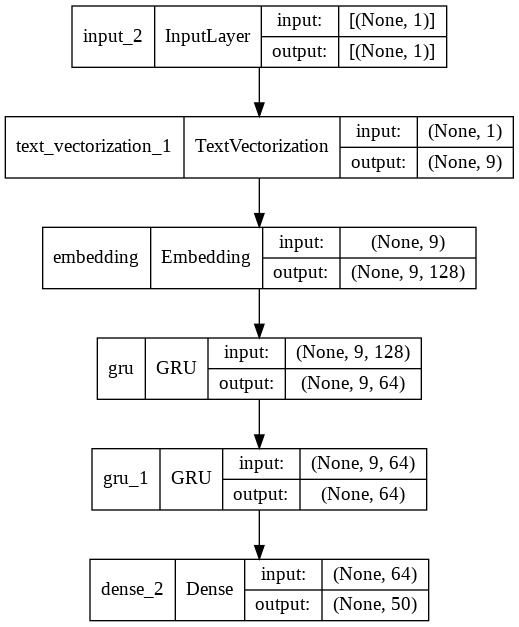

In [84]:
plot_model(model_3, to_file='model_3.png', expand_nested=True, show_shapes=True)

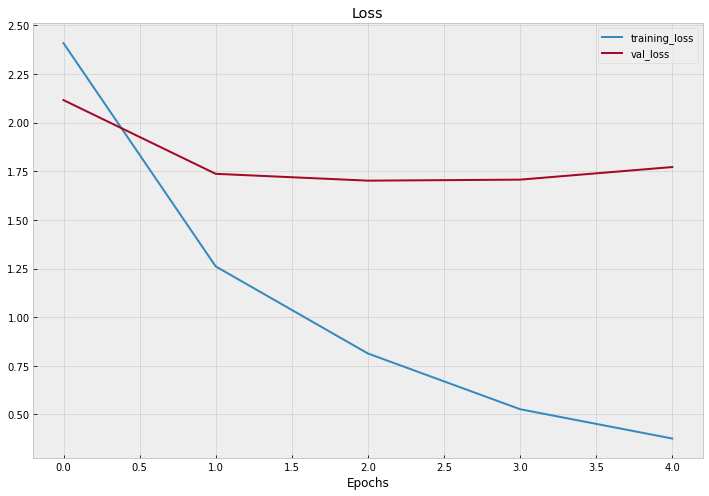

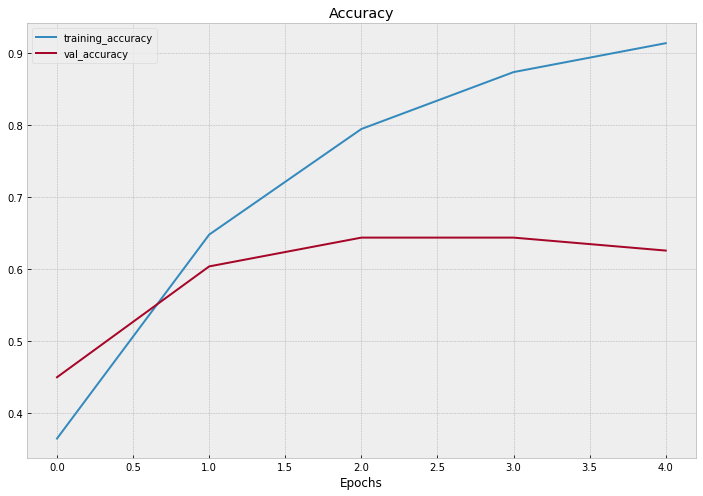

In [85]:
plot_loss_curves(model_3_history)

In [86]:
# Make predictions with the trained model
model_3_pred_probs = model_3.predict(test['text_tokens'])
model_3_pred_probs[:1], model_3_pred_probs.shape

(array([[1.4035265e-03, 3.5615475e-04, 1.0146180e-04, 3.1747782e-05,
         1.5745704e-03, 4.4939434e-03, 8.2319330e-06, 2.5969823e-05,
         3.5289230e-03, 2.9093200e-05, 7.3068346e-05, 8.7505849e-03,
         8.7181352e-06, 4.4202624e-04, 2.5326968e-04, 2.4611040e-04,
         6.8298934e-05, 2.8236312e-04, 1.3651016e-04, 8.0347863e-06,
         2.8330713e-04, 1.0828812e-04, 9.8442484e-04, 8.5375708e-05,
         1.1539568e-05, 5.2459640e-03, 3.7533512e-06, 1.5595807e-04,
         9.0092317e-06, 1.0731330e-06, 4.1727594e-06, 6.4214102e-05,
         1.3157343e-02, 1.6065754e-02, 9.6414362e-05, 6.4110878e-05,
         3.8363950e-04, 2.8560063e-04, 6.3041627e-01, 1.1647856e-03,
         2.1248312e-01, 5.6822775e-03, 5.3955897e-05, 3.7008092e-02,
         3.4437678e-04, 2.1447450e-02, 2.5920586e-03, 1.1471681e-03,
         2.6942994e-02, 1.8847883e-03]], dtype=float32), (500, 50))

In [87]:
#This cell replace all values in numpy array into zeros except the highest value into one
model_3_pred = [tf.cast(x==np.max(x),tf.int32) for x in model_3_pred_probs]
model_3_pred=np.array(model_3_pred)
print(model_3_pred.shape,'\n',model_3_pred[0])

(500, 50) 
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 0 0 0 0 0 0 0 0 0 0 0]


In [88]:
model_3_results = calculate_results(test_y,model_3_pred)
model_3_results

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'accuracy': 62.6,
 'f1': 0.6228678267528186,
 'precision': 0.660610095393606,
 'recall': 0.626}

### Model 4: Bidirectional RNN model

In [89]:
# Build a bidirectional RNN in TensorFlow
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = embedding(x)
# x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x) # return_sequences=True required for stacking RNN layers
x = layers.Bidirectional(layers.LSTM(64))(x)
outputs = layers.Dense(50, activation="softmax")(x)
model_4 = tf.keras.Model(inputs, outputs, name="model_4_bidirectional")

In [90]:
model_4.summary()

Model: "model_4_bidirectional"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 9)                0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 9, 128)            1280000   
                                                                 
 bidirectional (Bidirectiona  (None, 128)              98816     
 l)                                                              
                                                                 
 dense_3 (Dense)             (None, 50)                6450      
                                                                 
Total params: 1,385,266
Trainable params: 1,3

In [91]:
# Compile model
model_4.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit model
model_4_history = model_4.fit(train['text_tokens'],
                              train_y,
                              epochs=5,
                              validation_data=(test['text_tokens'],test_y),
                              callbacks=[create_tensorboard_callback(dir_name='model_logs',
                                                                     experiment_name="model_4_bidirectional")])

Saving TensorBoard log files to: model_logs/model_4_bidirectional/20211213-200632
Epoch 1/5
171/171 [==============================] - 8s 19ms/step - loss: 0.1627 - accuracy: 0.1583 - val_loss: 0.0839 - val_accuracy: 0.1280
Epoch 2/5
171/171 [==============================] - 2s 13ms/step - loss: 0.0720 - accuracy: 0.3316 - val_loss: 0.0724 - val_accuracy: 0.4320
Epoch 3/5
171/171 [==============================] - 2s 13ms/step - loss: 0.0624 - accuracy: 0.4347 - val_loss: 0.0660 - val_accuracy: 0.5180
Epoch 4/5
171/171 [==============================] - 2s 13ms/step - loss: 0.0520 - accuracy: 0.5451 - val_loss: 0.0574 - val_accuracy: 0.5320
Epoch 5/5
171/171 [==============================] - 2s 13ms/step - loss: 0.0406 - accuracy: 0.6649 - val_loss: 0.0521 - val_accuracy: 0.5560


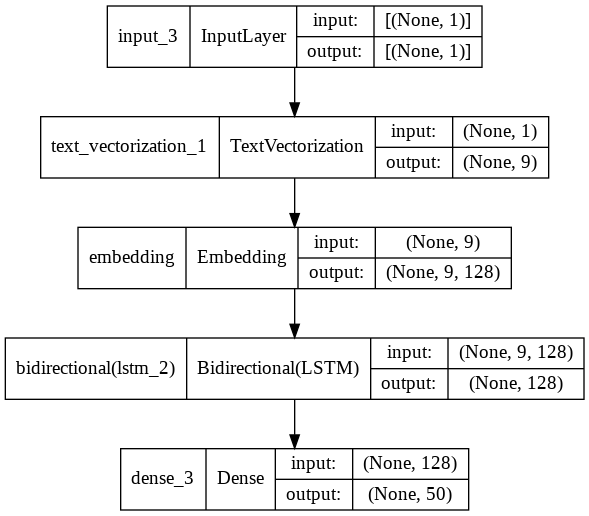

In [92]:
plot_model(model_4, to_file='model_4.png', expand_nested=True, show_shapes=True)

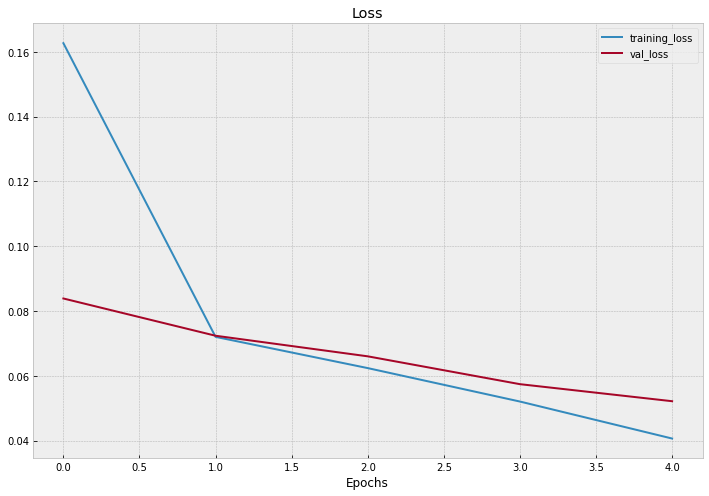

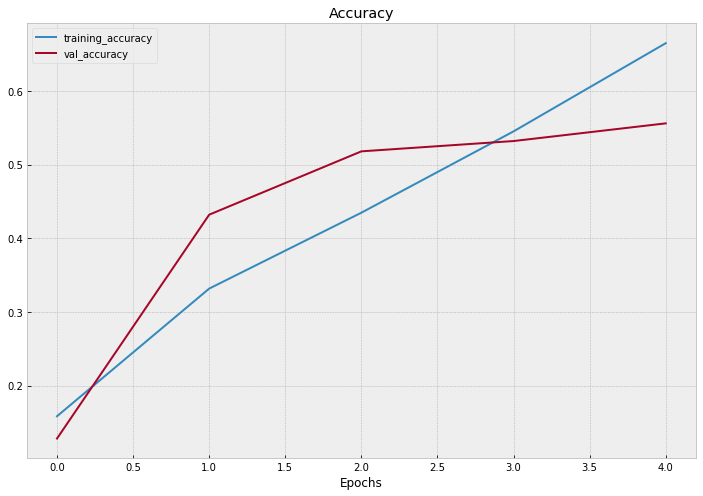

In [93]:
plot_loss_curves(model_4_history)

In [94]:
# Make predictions with the trained model
model_4_pred_probs = model_4.predict(test['text_tokens'])
model_4_pred_probs[:1], model_4_pred_probs.shape

(array([[1.8508174e-03, 3.6641327e-03, 3.1743709e-03, 1.0917371e-03,
         7.6771177e-02, 2.9533636e-02, 1.7259826e-03, 1.1868434e-03,
         3.6505738e-03, 7.7772688e-04, 1.1218438e-03, 1.2118162e-02,
         1.4566570e-03, 4.9921148e-03, 7.7888294e-04, 1.2343172e-03,
         1.3201996e-03, 7.3980042e-03, 1.0672956e-03, 1.2513443e-03,
         3.2705683e-04, 1.3362593e-03, 1.7506910e-03, 9.5520372e-04,
         1.9842999e-03, 9.6975248e-03, 1.9054009e-03, 2.8852727e-03,
         1.8123748e-03, 1.0295394e-03, 2.1480422e-05, 5.5002264e-04,
         5.2264603e-03, 1.3263654e-02, 7.0569565e-04, 2.0180752e-03,
         1.9568906e-03, 8.5115148e-04, 6.8930095e-01, 7.4718548e-03,
         3.2870080e-02, 1.0871884e-02, 7.2246278e-04, 4.3834085e-03,
         1.9587174e-03, 3.9407812e-02, 2.5433211e-03, 1.0891777e-03,
         3.3022889e-03, 1.6351322e-03]], dtype=float32), (500, 50))

In [95]:
#This cell replace all values in numpy array into zeros except the highest value into one
model_4_pred = [tf.cast(x==np.max(x),tf.int32) for x in model_4_pred_probs]
model_4_pred=np.array(model_4_pred)
print(model_4_pred.shape,'\n',model_4_pred[0])

(500, 50) 
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 0 0 0 0 0 0 0 0 0 0 0]


In [96]:
model_4_results = calculate_results(test_y,model_4_pred)
model_4_results

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'accuracy': 55.60000000000001,
 'f1': 0.5050217249609551,
 'precision': 0.4912650199163332,
 'recall': 0.556}

### Model 5: Conv1D

In [97]:
# Create 1-dimensional CNN to model sequences
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.Conv1D(filters=32, kernel_size=5, activation="relu")(x)
x = layers.GlobalMaxPool1D()(x)
# x = layers.Dense(64, activation="relu")(x)
outputs = layers.Dense(50, activation="softmax", name="output_layer")(x)
model_5 = tf.keras.Model(inputs, outputs, name="model_5_conv1d")

model_5.summary()

Model: "model_5_conv1d"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 9)                0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 9, 128)            1280000   
                                                                 
 conv1d (Conv1D)             (None, 5, 32)             20512     
                                                                 
 global_max_pooling1d (Globa  (None, 32)               0         
 lMaxPooling1D)                                                  
                                                                 
 output_layer (Dense)        (None, 50)             

In [98]:
# Compile model
model_5.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit the model
model_5_history = model_5.fit(train['text_tokens'],
                              train_y,
                              epochs=5,
                              batch_size=32,
                              validation_data=(test['text_tokens'],test_y),
                              callbacks=[create_tensorboard_callback(dir_name='model_logs',
                                                                     experiment_name="model_5_conv1d")])

Saving TensorBoard log files to: model_logs/model_5_conv1d/20211213-200651
Epoch 1/5
171/171 [==============================] - 4s 10ms/step - loss: 2.4436 - accuracy: 0.4215 - val_loss: 2.0059 - val_accuracy: 0.5820
Epoch 2/5
171/171 [==============================] - 1s 8ms/step - loss: 1.1773 - accuracy: 0.7449 - val_loss: 1.5546 - val_accuracy: 0.6560
Epoch 3/5
171/171 [==============================] - 1s 8ms/step - loss: 0.6879 - accuracy: 0.8553 - val_loss: 1.3393 - val_accuracy: 0.7000
Epoch 4/5
171/171 [==============================] - 1s 8ms/step - loss: 0.4223 - accuracy: 0.9231 - val_loss: 1.2260 - val_accuracy: 0.7260
Epoch 5/5
171/171 [==============================] - 1s 8ms/step - loss: 0.2583 - accuracy: 0.9606 - val_loss: 1.1791 - val_accuracy: 0.7260


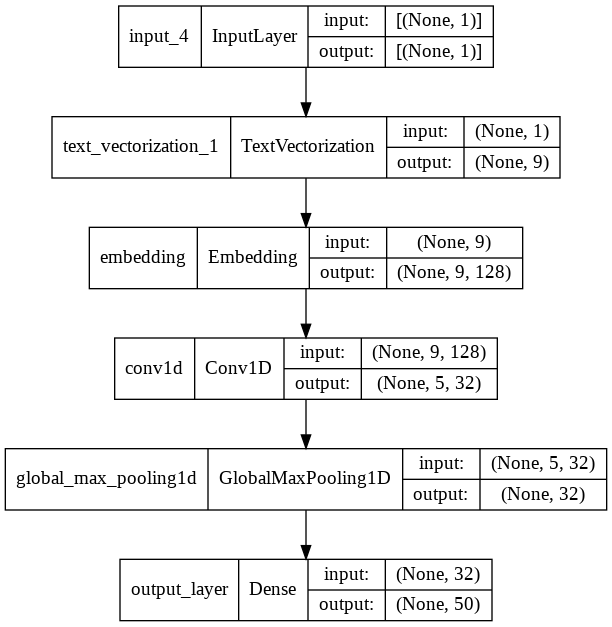

In [99]:
plot_model(model_5, to_file='model_5.png', expand_nested=True, show_shapes=True)

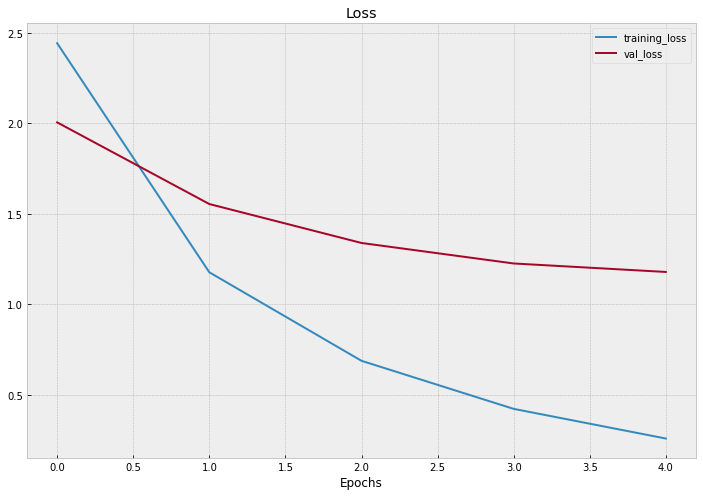

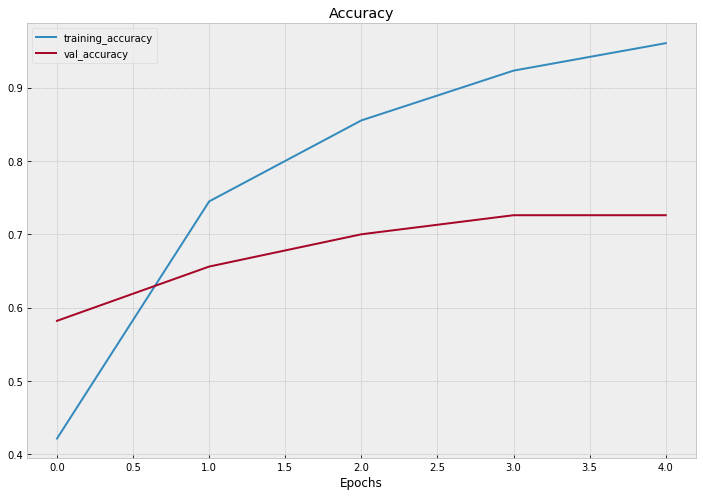

In [100]:
plot_loss_curves(model_5_history)

In [101]:
model_5.summary()

Model: "model_5_conv1d"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 9)                0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 9, 128)            1280000   
                                                                 
 conv1d (Conv1D)             (None, 5, 32)             20512     
                                                                 
 global_max_pooling1d (Globa  (None, 32)               0         
 lMaxPooling1D)                                                  
                                                                 
 output_layer (Dense)        (None, 50)             

In [102]:
# Make predictions with our 1D CNN
model_5_pred_probs = model_5.predict(test['text_tokens'])
model_5_pred_probs[:1], model_5_pred_probs.shape

(array([[2.6943375e-04, 4.4486405e-06, 2.7225703e-06, 2.4340648e-04,
         2.1829025e-03, 5.6145655e-05, 3.0875795e-09, 5.1528536e-04,
         1.3174916e-03, 8.1217288e-05, 5.9242506e-05, 1.2227906e-06,
         1.7992913e-04, 1.9414333e-04, 2.6666719e-04, 3.8229818e-03,
         2.7083026e-04, 3.8617777e-06, 2.1583622e-03, 3.1993454e-04,
         4.2699270e-05, 4.4153450e-07, 7.7327750e-05, 2.0704414e-03,
         3.2622855e-02, 4.6057128e-03, 9.9065392e-07, 5.0908449e-04,
         1.5132179e-07, 4.7381121e-07, 2.1988239e-10, 2.1688771e-03,
         7.9477531e-06, 2.9789002e-05, 2.9749058e-03, 8.5962215e-09,
         3.3945438e-05, 2.1863401e-05, 1.1741427e-03, 9.1843470e-04,
         7.9379034e-01, 3.0015687e-02, 4.1750519e-04, 1.0761493e-02,
         1.0766474e-03, 8.5924901e-02, 3.9626351e-03, 5.3975931e-03,
         8.6489860e-03, 7.9382659e-04]], dtype=float32), (500, 50))

In [103]:
#This cell replace all values in numpy array into zeros except the highest value into one
model_5_pred = [tf.cast(x==np.max(x),tf.int32) for x in model_5_pred_probs]
model_5_pred=np.array(model_5_pred)
print(model_5_pred.shape,'\n',model_5_pred[0])

(500, 50) 
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 0]


In [104]:
model_5_results = calculate_results(test_y,model_5_pred)
model_5_results

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'accuracy': 72.6,
 'f1': 0.7133816578334712,
 'precision': 0.7409928981813931,
 'recall': 0.726}

### Model 6: TensorFlow Hub Pretrained Sentence Encoder
Now we've built a few of our own models, let's try and use transfer learning for NLP, specifically using TensorFlow Hub's Universal Sentence Encoder

In [105]:
sample_sentence="There's a flood in my street!"

In [106]:
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
embed_samples = embed([sample_sentence,
                       "When you can the universal sentence encoder on a sentence, it turns it into numbers."])
print(embed_samples[0][:10],embed_samples.shape)

tf.Tensor(
[-0.01157024  0.0248591   0.0287805  -0.01271502  0.03971543  0.08827759
  0.02680986  0.05589837 -0.01068731 -0.0059729 ], shape=(10,), dtype=float32) (2, 512)


In [107]:
# Create a Keras Layer using the USE pretrained layer from tensorflow hub
sentence_encoder_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        input_shape=[],
                                        dtype=tf.string,
                                        trainable=False,
                                        name="USE")

In [108]:
# Create model using the Sequential API
model_6 = tf.keras.Sequential([
  sentence_encoder_layer,
  layers.Dense(64, activation="relu"),
  layers.Dense(50, activation="softmax", name="output_layer")                               
], name="model_6_USE")

# Compile
model_6.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

model_6.summary()

Model: "model_6_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_4 (Dense)             (None, 64)                32832     
                                                                 
 output_layer (Dense)        (None, 50)                3250      
                                                                 
Total params: 256,833,906
Trainable params: 36,082
Non-trainable params: 256,797,824
_________________________________________________________________


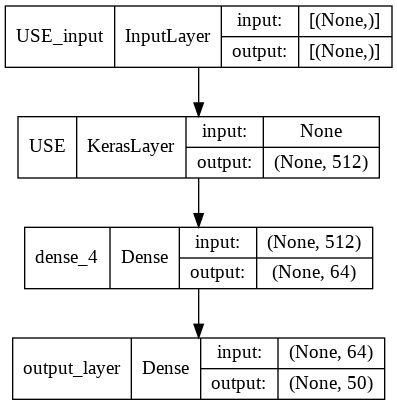

In [109]:
plot_model(model_6, to_file='model_6.png', expand_nested=True, show_shapes=True)

In [110]:
# Train a classifier on top of USE pretrained embeddings
model_6_history = model_6.fit(train['text_tokens'],
                              train_y,
                              epochs=10,
                              validation_data=(test['text_tokens'], test_y),
                              callbacks=[create_tensorboard_callback('model_logs',
                                                                     "tf_hub_sentence_encoder")])

Saving TensorBoard log files to: model_logs/tf_hub_sentence_encoder/20211213-200713
Epoch 1/10
171/171 [==============================] - 7s 24ms/step - loss: 3.1160 - accuracy: 0.2650 - val_loss: 2.5134 - val_accuracy: 0.4560
Epoch 2/10
171/171 [==============================] - 3s 20ms/step - loss: 2.1300 - accuracy: 0.4846 - val_loss: 1.8328 - val_accuracy: 0.5820
Epoch 3/10
171/171 [==============================] - 3s 19ms/step - loss: 1.6149 - accuracy: 0.6200 - val_loss: 1.4779 - val_accuracy: 0.6560
Epoch 4/10
171/171 [==============================] - 3s 19ms/step - loss: 1.3131 - accuracy: 0.6871 - val_loss: 1.2551 - val_accuracy: 0.6980
Epoch 5/10
171/171 [==============================] - 3s 19ms/step - loss: 1.1119 - accuracy: 0.7234 - val_loss: 1.1087 - val_accuracy: 0.7120
Epoch 6/10
171/171 [==============================] - 3s 19ms/step - loss: 0.9703 - accuracy: 0.7506 - val_loss: 0.9732 - val_accuracy: 0.7500
Epoch 7/10
171/171 [==============================] - 3s 1

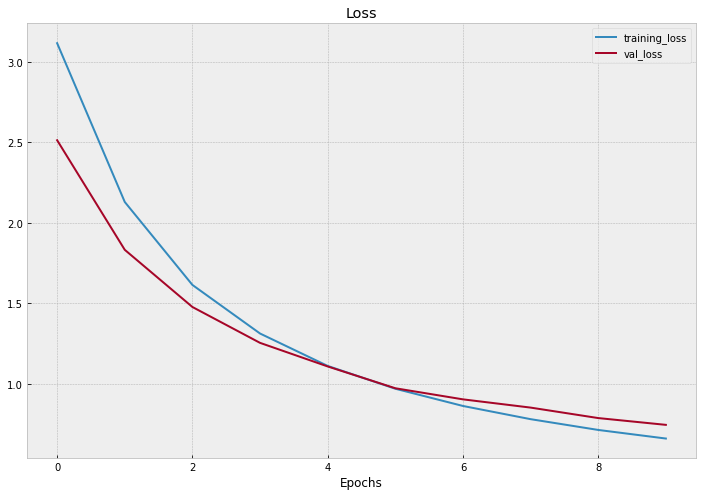

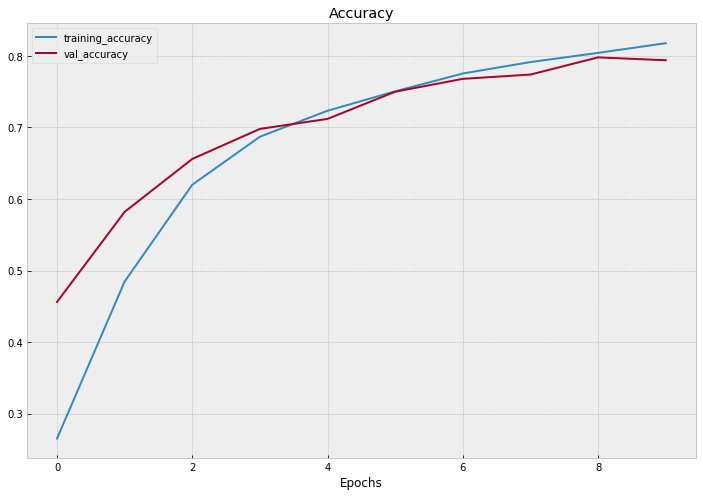

In [111]:
plot_loss_curves(model_6_history)

In [112]:
model_6_pred_probs = model_6.predict(test['text_tokens'])
model_6_pred_probs[:1]

array([[1.6756864e-04, 3.0874278e-04, 2.6630994e-03, 3.7142935e-03,
        3.0370945e-02, 5.7417173e-03, 1.6639062e-03, 8.1335363e-04,
        5.2810949e-03, 2.3227090e-04, 2.9662380e-04, 5.5129360e-05,
        3.4608561e-04, 9.1975329e-05, 5.4289389e-04, 2.1251151e-04,
        1.4440374e-03, 6.7200367e-03, 2.1803724e-03, 7.0885621e-04,
        5.8327056e-04, 3.2796524e-04, 1.2653347e-03, 2.3159981e-03,
        2.1417725e-03, 7.8497292e-04, 1.7833861e-04, 3.6676874e-04,
        5.6659548e-05, 1.5830634e-04, 1.6329081e-05, 9.2984014e-04,
        3.6478341e-03, 4.0704155e-05, 1.2169392e-02, 1.7351286e-02,
        1.3697549e-03, 6.6683637e-03, 2.0643434e-02, 8.0942931e-03,
        4.2378941e-01, 3.0055633e-02, 1.4720650e-03, 1.0035620e-01,
        2.3227479e-02, 1.5833600e-01, 5.1738672e-02, 6.2435269e-03,
        5.7996061e-02, 4.1188127e-03]], dtype=float32)

In [113]:
#This cell replace all values in numpy array into zeros except the highest value into one
model_6_pred = [tf.cast(x==np.max(x),tf.int32) for x in model_6_pred_probs]
model_6_pred=np.array(model_6_pred)
print(model_6_pred.shape,'\n',model_6_pred[0])

(500, 50) 
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 0]


In [114]:
model_6_results=calculate_results(test_y,model_6_pred)
model_6_results

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'accuracy': 79.4,
 'f1': 0.7673635532082913,
 'precision': 0.7646878528170296,
 'recall': 0.794}

### Model 7: XLNet

In [115]:
from transformers import TFXLNetModel, XLNetTokenizer
xlnet_model = 'xlnet-base-cased'
xlnet_tokenizer = XLNetTokenizer.from_pretrained(xlnet_model)

In [116]:
tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased', do_lower_case=True)

In [117]:
tokenized_train = [tokenizer.tokenize(sent) for sent in train['text']]
tokenized_test = [tokenizer.tokenize(sent) for sent in test['text']]

print ("Tokenize the first sentence:")
print (tokenized_train[88])

Tokenize the first sentence:
['▁who', '▁were', '▁the', '▁five', '▁', 'mar', 'x', '▁brothers']


In [118]:
# Set the maximum sequence length. 
MAX_LEN = 64

In [119]:
input_ids_train = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_train]
input_ids_test = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_test]

In [120]:
# Pad our input tokens

input_ids_train = pad_sequences(input_ids_train, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
input_ids_test = pad_sequences(input_ids_test, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")


In [121]:
# Create attention masks
attention_masks_train = []
attention_masks_test = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids_train:
  seq_mask = [float(i>0) for i in seq]
  attention_masks_train.append(seq_mask)

for seq in input_ids_test:
  seq_mask = [float(i>0) for i in seq]
  attention_masks_test.append(seq_mask)

In [122]:
def create_model_xlnet(xlnet_model):
    word_inputs = tf.keras.Input(shape=(64,), name='word_inputs', dtype='int32')

    
    xlnet = TFXLNetModel.from_pretrained(xlnet_model)
    xlnet_encodings = xlnet(word_inputs)[0]

    # Collect last step from last hidden state (CLS)
    doc_encoding = tf.squeeze(xlnet_encodings[:, -1:, :], axis=1)
    
    doc_encoding = tf.keras.layers.Dropout(.1)(doc_encoding)
     
    outputs = tf.keras.layers.Dense(50, activation='softmax', name='outputs')(doc_encoding)

    model = tf.keras.Model(inputs=[word_inputs], outputs=[outputs])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5), loss='categorical_crossentropy', metrics=['accuracy'])

    return model
#learning rate = 2e-5

In [123]:
xlnet = create_model_xlnet(xlnet_model)
xlnet.summary()

Some layers from the model checkpoint at xlnet-base-cased were not used when initializing TFXLNetModel: ['lm_loss']
- This IS expected if you are initializing TFXLNetModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFXLNetModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFXLNetModel were initialized from the model checkpoint at xlnet-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFXLNetModel for predictions without further training.


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 word_inputs (InputLayer)    [(None, 64)]              0         
                                                                 
 tfxl_net_model (TFXLNetMode  TFXLNetModelOutput(last_  116718336
 l)                          hidden_state=(None, 64,             
                             768),                               
                              mems=((64, None, 768),             
                              (64, None, 768),                   
                              (64, None, 768),                   
                              (64, None, 768),                   
                              (64, None, 768),                   
                              (64, None, 768),                   
                              (64, None, 768),                   
                              (64, None, 768),               

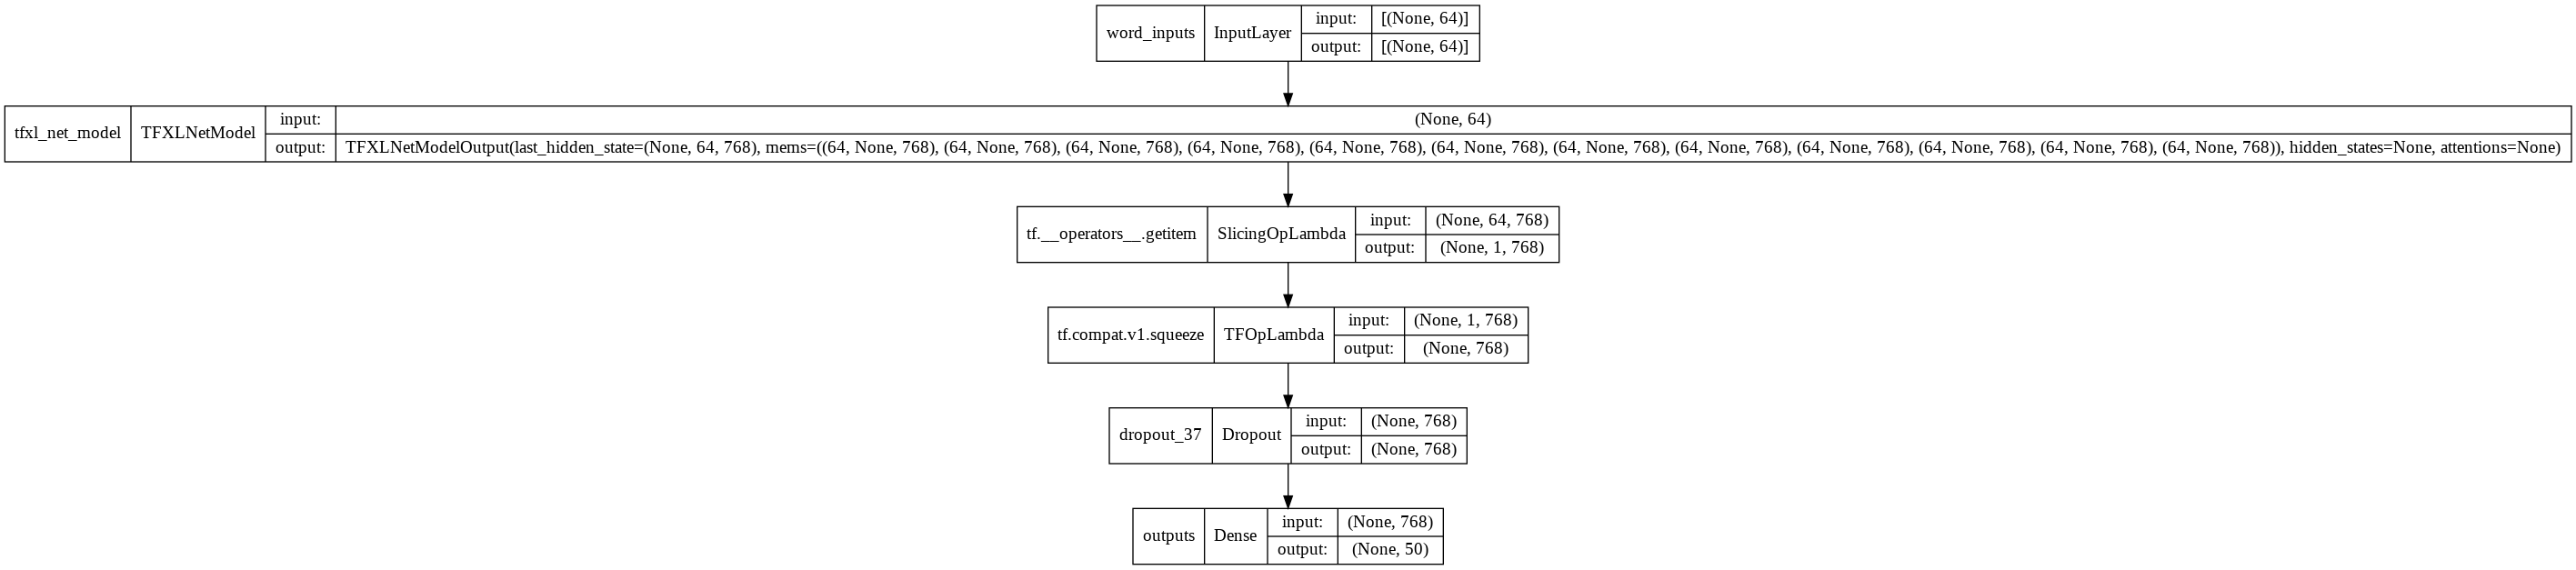

In [124]:
plot_model(xlnet, to_file='model_xl.png', expand_nested=True, show_shapes=True)

In [125]:
model_7_history = xlnet.fit(input_ids_train,train_y,validation_data=(input_ids_test,test_y), epochs=8)

Epoch 1/8


171/171 [==============================] - 194s 1s/step - loss: 2.9839 - accuracy: 0.3202 - val_loss: 1.9114 - val_accuracy: 0.5540
Epoch 2/8
171/171 [==============================] - 173s 1s/step - loss: 1.5044 - accuracy: 0.6251 - val_loss: 1.1943 - val_accuracy: 0.7140
Epoch 3/8
171/171 [==============================] - 173s 1s/step - loss: 0.8736 - accuracy: 0.7749 - val_loss: 0.7547 - val_accuracy: 0.7880
Epoch 4/8
171/171 [==============================] - 173s 1s/step - loss: 0.6936 - accuracy: 0.8131 - val_loss: 0.6614 - val_accuracy: 0.8360
Epoch 5/8
171/171 [==============================] - 173s 1s/step - loss: 0.4278 - accuracy: 0.8813 - val_loss: 0.5781 - val_accuracy: 0.8500
Epoch 6/8
171/171 [==============================] - 173s 1s/step - loss: 0.3055 - accuracy: 0.9151 - val_loss: 0.5964 - val_accuracy: 0.8800
Epoch 7/8
171/171 [==============================] - 173s 1s/step - loss: 0.2459 - accuracy: 0.9287 - val_loss: 0.5539 - val_accuracy: 0.8940
Epoch 8/8
171/17

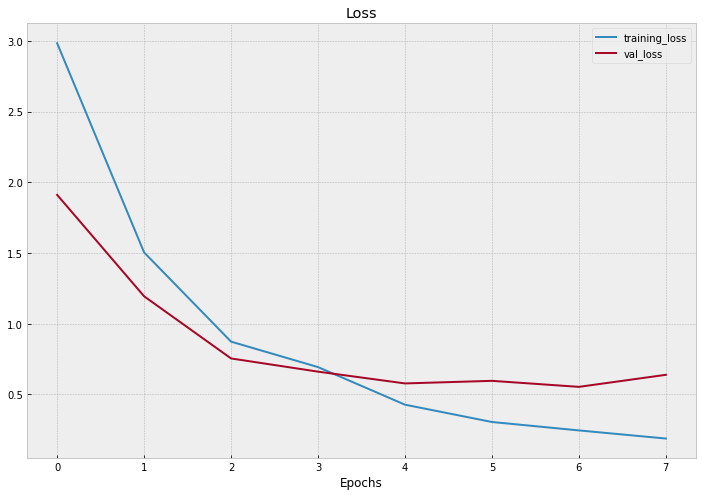

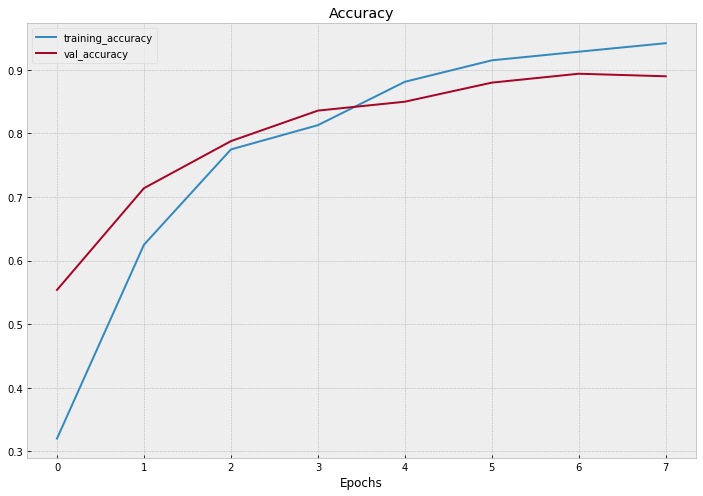

In [126]:
plot_loss_curves(model_7_history)

In [127]:
model_7_pred_probs = xlnet.predict(input_ids_test)
model_7_pred_probs[:1]

array([[1.0920012e-08, 7.1711486e-07, 3.4671306e-08, 2.0907869e-08,
        3.6229098e-06, 4.4583310e-09, 6.6106440e-11, 3.4598474e-06,
        3.9350920e-10, 1.9031703e-09, 3.5174902e-10, 2.0985095e-08,
        3.1904795e-11, 1.0739486e-11, 1.3780026e-10, 8.2617341e-08,
        2.9174609e-09, 2.1891040e-08, 2.1292048e-07, 5.5156598e-08,
        8.9552504e-10, 6.4185399e-09, 2.4151257e-08, 1.7276330e-08,
        1.9984914e-06, 2.1137656e-07, 2.5476887e-10, 4.3563584e-09,
        6.5610450e-09, 1.5077479e-08, 2.5159887e-08, 1.5041073e-10,
        6.7806677e-11, 1.7919939e-09, 3.4533619e-07, 4.6433762e-08,
        2.6094105e-07, 1.4551680e-08, 1.9781386e-07, 2.8104687e-08,
        9.9997091e-01, 1.1639512e-08, 9.5804475e-09, 1.3150605e-05,
        4.0571007e-07, 1.8769515e-09, 5.7870992e-09, 6.2915042e-08,
        3.0166220e-06, 8.0732798e-07]], dtype=float32)

In [128]:
#This cell replace all values in numpy array into zeros except the highest value into one
model_7_pred = [tf.cast(x==np.max(x),tf.int32) for x in model_7_pred_probs]
model_7_pred=np.array(model_7_pred)
print(model_7_pred.shape,'\n',model_7_pred[0])


(500, 50) 
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 0]


In [129]:
model_7_results=calculate_results(test_y,model_7_pred)
model_7_results

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'accuracy': 89.0,
 'f1': 0.885499549308553,
 'precision': 0.8998902882205514,
 'recall': 0.89}

## Comparing the peformance of each of our models

In [130]:
# Combine model results into a DataFrame
all_model_results = pd.DataFrame({"1_SVM_without Stopwords": model_0_results,
                                  "1_SVM_with Stopwords": model_1_results,
                                  "2_LSTM": model_2_results,
                                  "3_GRU": model_3_results,
                                  "4_Bidirectional": model_4_results,
                                  "5_Conv1d": model_5_results,
                                  "6_tf_hub_use_encoder": model_6_results,
                                  "7_XLNet": model_7_results})
all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
1_SVM_without Stopwords,37.0,0.782329,0.388,0.474673
1_SVM_with Stopwords,68.6,0.870170,0.712,0.753880
2_LSTM,65.2,0.652742,0.652,0.638841
3_GRU,62.6,0.660610,0.626,0.622868
4_Bidirectional,55.6,0.491265,0.556,0.505022
5_Conv1d,72.6,0.740993,0.726,0.713382
6_tf_hub_use_encoder,79.4,0.764688,0.794,0.767364
7_XLNet,89.0,0.899890,0.890,0.885500


In [131]:
# Reduce the accuracy to the same scale as other metrics
all_model_results["accuracy"]=all_model_results["accuracy"]/100
# all_model_results

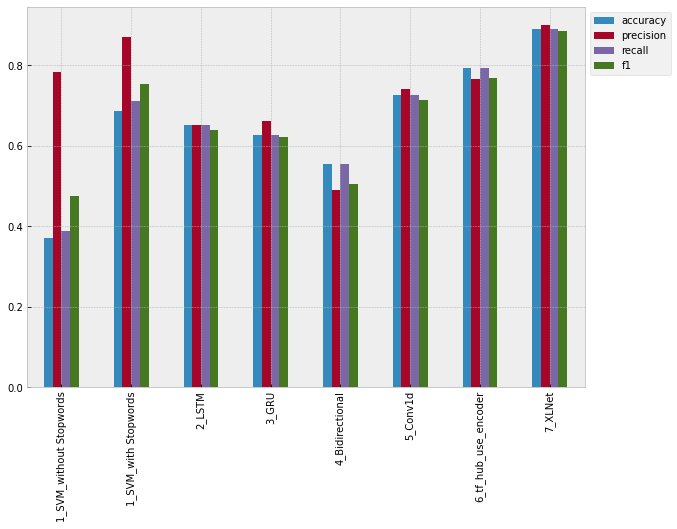

In [132]:
  # Plot and compare all of the model results
all_model_results.plot(kind="bar", figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0));

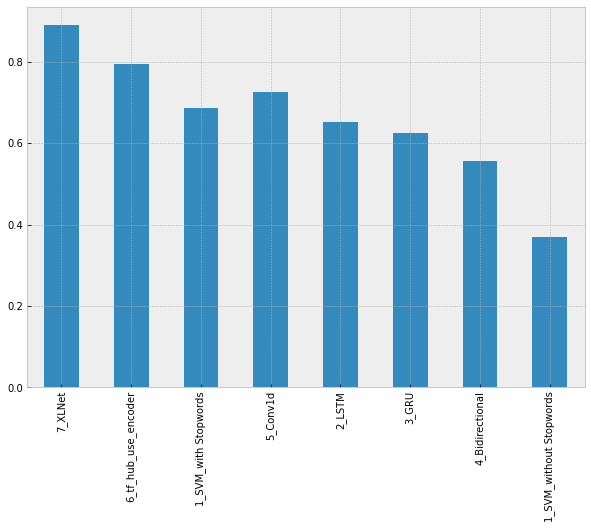

In [133]:
# Sort model results by f1-score
all_model_results.sort_values("f1", ascending=False)["accuracy"].plot(kind="bar", figsize=(10, 7));

## Saving and loading a trained model

In [134]:
# Save TF Hub Sentence Encoder model to HDF5 format
model_6.save("model_6.h5")


In [135]:
# Load model with custom Hub Layer (required HDF5 format)
import tensorflow_hub as hub
loaded_model_6 = tf.keras.models.load_model("model_6.h5",
                                            custom_objects={"KerasLayer": hub.KerasLayer})

In [136]:
# How does our loaded model perform?
loaded_model_6.evaluate(test['text_tokens'],test_y)

16/16 [==============================] - 1s 16ms/step - loss: 0.7460 - accuracy: 0.7940


[0.7459681034088135, 0.7940000295639038]

In [137]:
def classify_questions(text):

  pred = loaded_model_6.predict([text])
  x = [tf.cast(x==np.max(x),tf.int32) for x in pred]
  x=np.array(x)
  return encoder.inverse_transform(x)

In [138]:
classify_questions('how are you')

array([['DESC:manner']], dtype=object)

In [139]:
classify_questions('How far did you have to travel from home to school?')

array([['NUM:count']], dtype=object)

Done by Mohammad Zahrawi
eng.moh.Zahrawi@gmail.com